<a href="https://colab.research.google.com/github/mihneacoman/Sentiment-Analysis-IMDB-reviews/blob/main/Another_copy_of_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

---




**Importing the csv file and renaming the columns.**

---

---





In [1]:
import numpy as np
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/Proiect IMDB/"
df = pd.read_csv(path+'IMDB Dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the required libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from bs4 import BeautifulSoup
from nltk.corpus import wordnet as wn
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = df.rename(columns={'review': 'text'})
df['sentiment'] = df['sentiment'].map({'negative':-1,'positive':1})
df

,text,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,-1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",-1
49997,I am a Catholic taught in parochial elementary...,-1
49998,I'm going to have to disagree with the previou...,-1




> Add blockquote



---


---


**Choosing a random sample of 2000 positive and 2000 negative reviews.**

---


---





In [4]:
print(df['sentiment'].value_counts())

# Impart setul de date dupa sentiment (negativ si pozitiv)
df_negative = df[df['sentiment'] == -1]
df_positive = df[df['sentiment'] == 1]

min_samples = 2000

# Selectam random 2000 de exemple din fiecare sentiment
df_negative_sampled = df_negative.sample(n=min_samples)
df_positive_sampled = df_positive.sample(n=min_samples)

# Le combinam intr-un singur dataframe
df_sampled = pd.concat([df_negative_sampled, df_positive_sampled])

# Amestecam randurile
df_sampled = df_sampled.sample(frac=1).reset_index(drop=True)

print(df_sampled['sentiment'].value_counts())

df_sampled


sentiment
 1    25000
-1    25000
Name: count, dtype: int64
sentiment
 1    2000
-1    2000
Name: count, dtype: int64


,text,sentiment
0,I saw this film on TV many years ago and I saw...,1
1,Nell Shipman must have been paid a hefty sum o...,-1
2,"BABY FACE is a fast paced, wise cracking, know...",1
3,I was fortunate enough to catch this film at t...,1
4,"Everyone wants Duvall and Jones back, come on!...",1
...,...,...
3995,Somewhere in his non-fiction book DANSE MACABR...,-1
3996,GoldenEye is a masterpiece. The storyline is a...,1
3997,"Chances are, you'll think this movie is incred...",1
3998,"I saw a trailer for this on Afro Promo, the co...",1




---



---
**Analiza setului de date**


---



---




<Axes: xlabel='sentiment'>

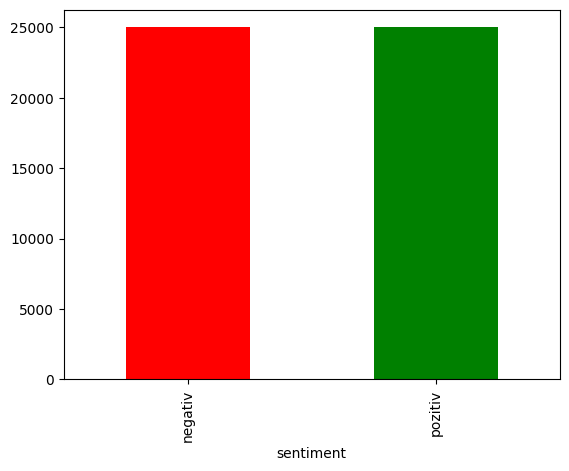

In [5]:
label_map = {-1: "negativ", 1: "pozitiv"}
sentiment_counts = df["sentiment"].value_counts().sort_index()
sentiment_counts.index = sentiment_counts.index.map(label_map)
sentiment_counts.plot(kind="bar", color=["red", "green"])

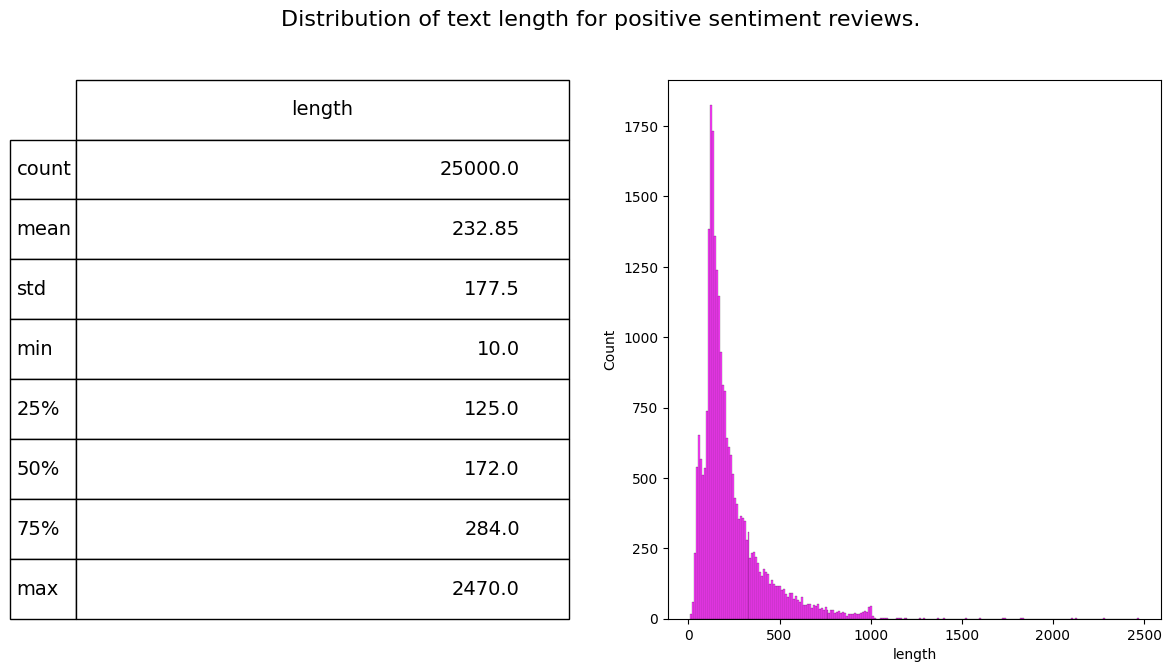

In [6]:
import seaborn as sns

review_len = pd.Series([len(review.split()) for review in df['text']])

fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==1]['length'], ax=ax1,color='magenta')
describe = df.length[df.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

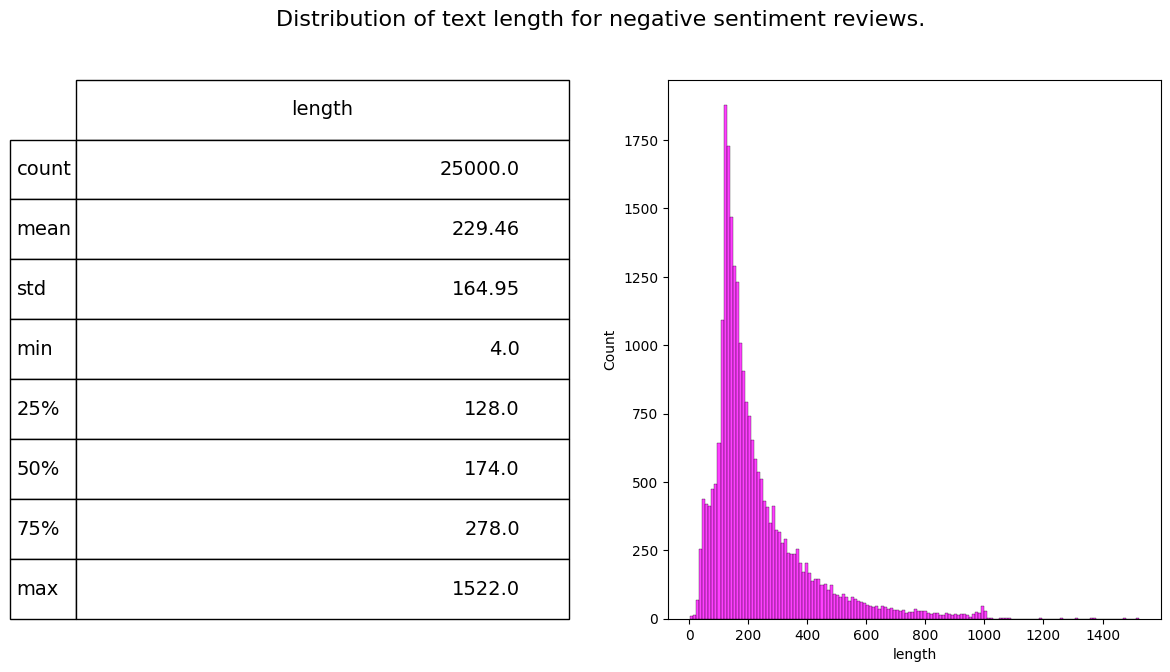

In [7]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==-1]['length'], ax=ax1,color='magenta')
describe = df.length[df.sentiment==-1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment reviews.', fontsize=16)

plt.show()



---



---


**TF_IDF vectorization and logistic regression**


---



---



In [8]:
# loading the spacy model for tokenization
nlp = spacy.load("en_core_web_sm")

lemmatizer = WordNetLemmatizer()

# list of common negations (we wish to keep them)
negations = {"not", "no", "n't", "isn't", "aren't", "won't", "can't", "never", "nothing"}

def review_to_words(review):

    # removing HTML tags and hashtags
    review = re.sub(r"<.*?>", " ", review)
    review = re.sub(r"(@[A-Za-z0-9_]+)|(#\S+)", " ", review)

    doc = nlp(review.lower())

    clean_tokens = []
    for token in doc:
        # removing punctuation, spaces and stopwords (excluding negations)
        if token.is_punct or token.is_space:
            continue
        if token.is_stop and token.text not in negations:
            continue
        # lematizare
        clean_tokens.append(token.lemma_)

    return clean_tokens

df_sampled['processed_text'] = df_sampled['text'].apply(review_to_words)

# checking that preprocessing worked
print(df_sampled[['text', 'processed_text']].head())

#transforming tokens into strings
df_sampled['processed_text'] = df_sampled['processed_text'].apply(lambda tokens: ' '.join(tokens))

#splitting the dataset
X_text_train, X_text_test, y_train, y_test = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

# vectorization of X_train and X_test
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_text_train)

X_test = vectorizer.transform(X_text_test)

# training the Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)
model.fit(X_train, y_train)

# predictions and evaluation
y_pred_lr = model.predict(X_test)
y_true_lr = y_test
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

                                                text  \
0  I saw this film on TV many years ago and I saw...   
1  Nell Shipman must have been paid a hefty sum o...   
2  BABY FACE is a fast paced, wise cracking, know...   
3  I was fortunate enough to catch this film at t...   
4  Everyone wants Duvall and Jones back, come on!...   

                                      processed_text  
0  [see, film, tv, year, ago, see, film, get, tap...  
1  [nell, shipman, pay, hefty, sum, money, promot...  
2  [baby, face, fast, pace, wise, cracking, know,...  
3  [fortunate, catch, film, phoenix, film, festiv...  
4  [want, duvall, jones, come, viewer, say, thing...  
Accuracy: 0.8633333333333333

Classification Report:
               precision    recall  f1-score   support

          -1       0.90      0.82      0.86       619
           1       0.83      0.91      0.87       581

    accuracy                           0.86      1200
   macro avg       0.87      0.86      0.86      1200
weighte



---



---



**Verifying a new review.**


---



---



In [9]:
new_text = "I did not enjoy this movie"
print(f"The review is: {new_text}")
tokens = review_to_words(new_text)
prop = ' '.join(tokens)

X_new = vectorizer.transform([prop])

y_pred_new = model.predict(X_new)

print("Preprocessed review:", prop)
print("Prediction for this review:", y_pred_new)

The review is: I did not enjoy this movie
Preprocessed review: not enjoy movie
Prediction for this review: [1]




---

False positives and false negatives


---



In [10]:
# resetting the index to match X_test
df_test = df_sampled.iloc[y_test.index].copy()
df_test["true_label"] = y_test.values
df_test["predicted_label"] = y_pred_lr

# false positives:
false_positives = df_test[(df_test["true_label"] == -1) & (df_test["predicted_label"] == 1)]

# false negatives:
false_negatives = df_test[(df_test["true_label"] == 1) & (df_test["predicted_label"] == -1)]

# printing a few examples
print("FALSE POSITIVES (predicted 1, true -1):")
print(false_positives[["text", "true_label", "predicted_label"]].head(5))

print("\nFALSE NEGATIVES (predicted -1, true 1):")
print(false_negatives[["text", "true_label", "predicted_label"]].head(5))
#pd.set_option("display.max_colwidth", None)

FALSE POSITIVES (predicted 1, true -1):
                                                   text  true_label  \
1637  The Twilight Zone has achieved a certain mytho...          -1   
3710  Yes.A real stinker. I saw this movie on the ad...          -1   
625   My tolerance for shlocky direction was overwhe...          -1   
566   The most horrible retelling of a great series....          -1   
2471  Nobody, but nobody, could chew the scenery lik...          -1   

      predicted_label  
1637                1  
3710                1  
625                 1  
566                 1  
2471                1  

FALSE NEGATIVES (predicted -1, true 1):
                                                   text  true_label  \
3640  Saw this movie at the Rotterdam IFF. You may q...           1   
1694  I found this flick enjoyable and involving to ...           1   
3542  ...........as I was when I saw this movie) I w...           1   
2369  This is not a good movie but I still like it. ...         

Handling negations.

In [11]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

#function that replaces negated words with their antonyms
def Negation(sentence):

    i = 1
    while i < len(sentence):
        if sentence[i-1] in ['not', "n't"]:
            antonyms = []

            for syn in wn.synsets(sentence[i]):
                for lemma in syn.lemmas():
                    if lemma.antonyms():
                        antonyms.append(lemma.antonyms()[0].name())

            if 'bad' in antonyms:
                sentence[i] = 'bad'
            elif antonyms:
                sentence[i] = antonyms[0]
            sentence[i-1] = ''
        i += 1

    return ' '.join([word for word in sentence if word])

df_sampled = df_sampled.drop('processed_text', axis=1)

df_sampled['processed_text'] = df_sampled['text'].apply(review_to_words)
df_sampled['processed_text'] = df_sampled['processed_text'].apply(Negation)

X_text_train, X_text_test, y_train, y_test = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_text_train)

X_test = vectorizer.transform(X_text_test)

# training the new model (that handles negations)
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)
model.fit(X_train, y_train)

# evaluation
y_pred_lr = model.predict(X_test)
y_true_lr = y_test
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Accuracy: 0.8408333333333333

Classification Report:
               precision    recall  f1-score   support

          -1       0.86      0.81      0.83       590
           1       0.82      0.87      0.85       610

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200



Bag of Words + Logistic Regression

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

X_text_train_bow, X_text_test_bow, y_train_bow, y_test_bow = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = vectorizer.fit_transform(X_text_train_bow)

X_test_bow = vectorizer.transform(X_text_test_bow)

model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)
model.fit(X_train_bow, y_train_bow)

y_pred_bow = model.predict(X_test_bow)
y_true_bow = y_test_bow
print("Accuracy:", accuracy_score(y_test_bow, y_pred_bow))
print("\nClassification Report:\n", classification_report(y_test_bow, y_pred_bow))

Accuracy: 0.8241666666666667

Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.81      0.82       587
           1       0.82      0.84      0.83       613

    accuracy                           0.82      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.82      0.82      1200



TF-IDF + Naive Bayes

In [13]:
from sklearn.naive_bayes import MultinomialNB

X_text_train_nb, X_text_test_nb, y_train_nb, y_test_nb = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_nb = vectorizer.fit_transform(X_text_train_nb)

X_test_nb = vectorizer.transform(X_text_test_nb)

model = MultinomialNB()
model.fit(X_train_nb, y_train_nb)

y_pred_nb = model.predict(X_test_nb)
y_true_nb = y_test_nb
print("Accuracy:", accuracy_score(y_test_nb, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test_nb, y_pred_nb))

Accuracy: 0.8533333333333334

Classification Report:
               precision    recall  f1-score   support

          -1       0.86      0.84      0.85       599
           1       0.84      0.87      0.86       601

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



BoW cu Naive Bayes

In [14]:
X_text_train_nb, X_text_test_nb, y_train_nb, y_test_nb = train_test_split(df_sampled['processed_text'], df_sampled['sentiment'], test_size=0.3)

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_nb = vectorizer.fit_transform(X_text_train_nb)

X_test_nb = vectorizer.transform(X_text_test_nb)

model = MultinomialNB()
model.fit(X_train_nb, y_train_nb)

y_pred_nb = model.predict(X_test_nb)
y_true_nb = y_test_nb
print("Accuracy:", accuracy_score(y_test_nb, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test_nb, y_pred_nb))

Accuracy: 0.835

Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.84      0.83       590
           1       0.84      0.83      0.84       610

    accuracy                           0.83      1200
   macro avg       0.83      0.84      0.83      1200
weighted avg       0.84      0.83      0.84      1200





---



---


**Adding a dependency tree derived feature.**


---


---




In [15]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    return text.lower()

# we extract SVO triplets
def extract_dependency_features(text):
    doc = nlp(text)
    triples = []
    for token in doc:
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            subject = [child for child in token.children if "subj" in child.dep_]
            obj = [child for child in token.children if "obj" in child.dep_ or "attr" in child.dep_]
            if subject and obj:
                s = subject[0].lemma_
                v = token.lemma_
                o = obj[0].lemma_
                triples.append(f"{s}_{v}_{o}")

    return " ".join(triples)

def preprocess_with_dependencies(text):
    text_clean = clean_text(text)
    tokens = text_clean.split()
    tokens_neg_handled = Negation(tokens)
    text_neg_handled = tokens_neg_handled
    text_lemmas = [lemmatizer.lemmatize(word) for word in text_neg_handled.split() if word not in stop_words]
    triple_features = extract_dependency_features(text_neg_handled)
    return " ".join(text_lemmas) + " " + triple_features

df_sampled['processed_text_tree'] = df_sampled['text'].apply(preprocess_with_dependencies)

X_train, X_test, y_train, y_test = train_test_split(df_sampled['processed_text_tree'], df_sampled['sentiment'], test_size=0.3)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced', C=1.0)
model.fit(X_train_vec, y_train)

# Predicții și metrice
y_pred_tree = model.predict(X_test_vec)
y_true_tree=y_test
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_tree))

Accuracy: 0.845

Classification Report:

              precision    recall  f1-score   support

          -1       0.87      0.81      0.84       599
           1       0.82      0.88      0.85       601

    accuracy                           0.84      1200
   macro avg       0.85      0.84      0.84      1200
weighted avg       0.85      0.84      0.84      1200



In [16]:
df_test_tree = df_sampled.iloc[y_test.index].copy()
df_test_tree["true_label"] = y_test.values
df_test_tree["predicted_label"] = y_pred_tree

# False positives
false_positives = df_test_tree[(df_test_tree["true_label"] == -1) & (df_test_tree["predicted_label"] == 1)]

# False negatives
false_negatives = df_test_tree[(df_test_tree["true_label"] == 1) & (df_test_tree["predicted_label"] == -1)]

# Printing a few examples
print("FALSE POSITIVES (predicted 1, true -1):")
print(false_positives[["text", "true_label", "predicted_label"]].head(5))

print("\nFALSE NEGATIVES (predicted -1, true 1):")
print(false_negatives[["text", "true_label", "predicted_label"]].head(5))

FALSE POSITIVES (predicted 1, true -1):
                                                   text  true_label  \
3180  Luchino Visconti was and is one of the most in...          -1   
1098  Heart of Darkness, a short novel written by Jo...          -1   
1977  The plot in Petites Coupures certainly left th...          -1   
1712  Don't be fooled by the other reviewers. Althou...          -1   
376   'Carolina Moon' is an adequate made-for-TV mov...          -1   

      predicted_label  
3180                1  
1098                1  
1977                1  
1712                1  
376                 1  

FALSE NEGATIVES (predicted -1, true 1):
                                                   text  true_label  \
3540  -love is hard to find in this fast food societ...           1   
2402  A kid with ideals who tries to change things a...           1   
1552  What is your freaking problem? Do you have not...           1   
3579  I saw this film as it was the second feature o...         



---



---
Transformers


---



---




In [17]:
!pip uninstall -y transformers
!pip install transformers datasets -q
from transformers import TrainingArguments
import transformers
print(transformers.__version__)

Found existing installation: transformers 4.55.2
Uninstalling transformers-4.55.2:
  Successfully uninstalled transformers-4.55.2
4.55.2


In [ ]:
import os
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# desabling wandb (external logging)
os.environ["WANDB_DISABLED"] = "true"

# we need the labels to be 0 and 1
df_test_bert = df_sampled.copy()
df_test_bert['label'] = df_test_bert['sentiment'].map({-1: 0, 1: 1})

# train/test split
train_df, test_df = train_test_split(df_test_bert, test_size=0.2, stratify=df_test_bert['label'])

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

# tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# model and data collator
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# hyperparameters
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# evaluation
preds_output = trainer.predict(test_dataset)
y_pred_bert = preds_output.predictions.argmax(-1)
y_true_bert = preds_output.label_ids

df_test_bert = test_df.copy()

df_test_bert["true_label"] = y_true_bert
df_test_bert["predicted_label"] = y_pred_bert

df_test_bert["true_label"] = df_test_bert["true_label"].map({0: -1, 1: 1})
df_test_bert["predicted_label"] = df_test_bert["predicted_label"].map({0: -1, 1: 1})

print("\nclassification report:")
print(classification_report(y_true_bert, y_pred_bert, target_names=["Negative", "Positive"]))

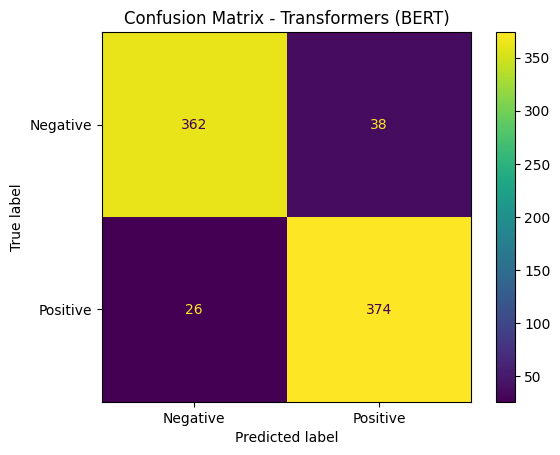

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_true_bert, y_pred_bert, display_labels=["Negative", "Positive"])
plt.title("Confusion Matrix - Transformers (BERT)")
plt.show()


Training loss plot.

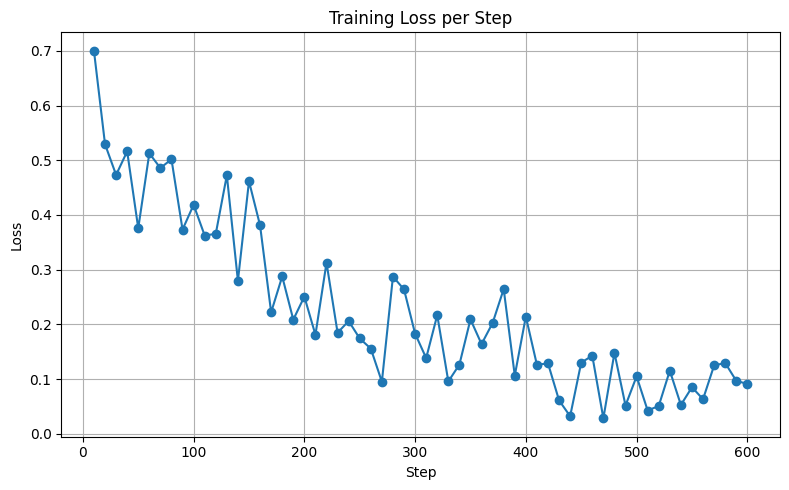

In [20]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

steps = []
losses = []

for entry in log_history:
    if "loss" in entry and "epoch" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss per Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


---



**Comparing the models.**

---



In [21]:
import pandas as pd
from sklearn.metrics import classification_report

y_pred_lr = y_pred_lr.ravel()
y_pred_tree = y_pred_tree.ravel()
y_pred_bert = y_pred_bert.ravel()

report_lr = classification_report(y_true_lr, y_pred_lr, target_names=["Negative", "Positive"], output_dict=True)
report_tree = classification_report(y_true_tree, y_pred_tree, target_names=["Negative", "Positive"], output_dict=True)
report_bert = classification_report(y_true_bert, y_pred_bert, target_names=["Negative", "Positive"], output_dict=True)

def extract_metrics(report, model_name):
    rows = []
    for cls in ["Negative", "Positive"]:
        row = {
            "Model": model_name,
            "Class": cls,
            "Precision": round(report[cls]["precision"], 2),
            "Recall": round(report[cls]["recall"], 2),
            "F1-Score": round(report[cls]["f1-score"], 2),
            "Support": int(report[cls]["support"])
        }
        rows.append(row)
    return rows

data = []
data += extract_metrics(report_lr, "Logistic Regression")
data += extract_metrics(report_tree, "Dependency Tree")
data += extract_metrics(report_bert, "Transformers")

comparison_df = pd.DataFrame(data)

print(comparison_df)

                 Model     Class  Precision  Recall  F1-Score  Support
0  Logistic Regression  Negative       0.86    0.81      0.83      590
1  Logistic Regression  Positive       0.82    0.87      0.85      610
2      Dependency Tree  Negative       0.87    0.81      0.84      599
3      Dependency Tree  Positive       0.82    0.88      0.85      601
4         Transformers  Negative       0.93    0.91      0.92      400
5         Transformers  Positive       0.91    0.94      0.92      400


                 Model       Error Type  Count
0  Logistic Regression  False Positives    110
1  Logistic Regression  False Negatives     54
2      Dependency Tree  False Positives    116
3      Dependency Tree  False Negatives     70
4         Transformers  False Positives     38
5         Transformers  False Negatives     26


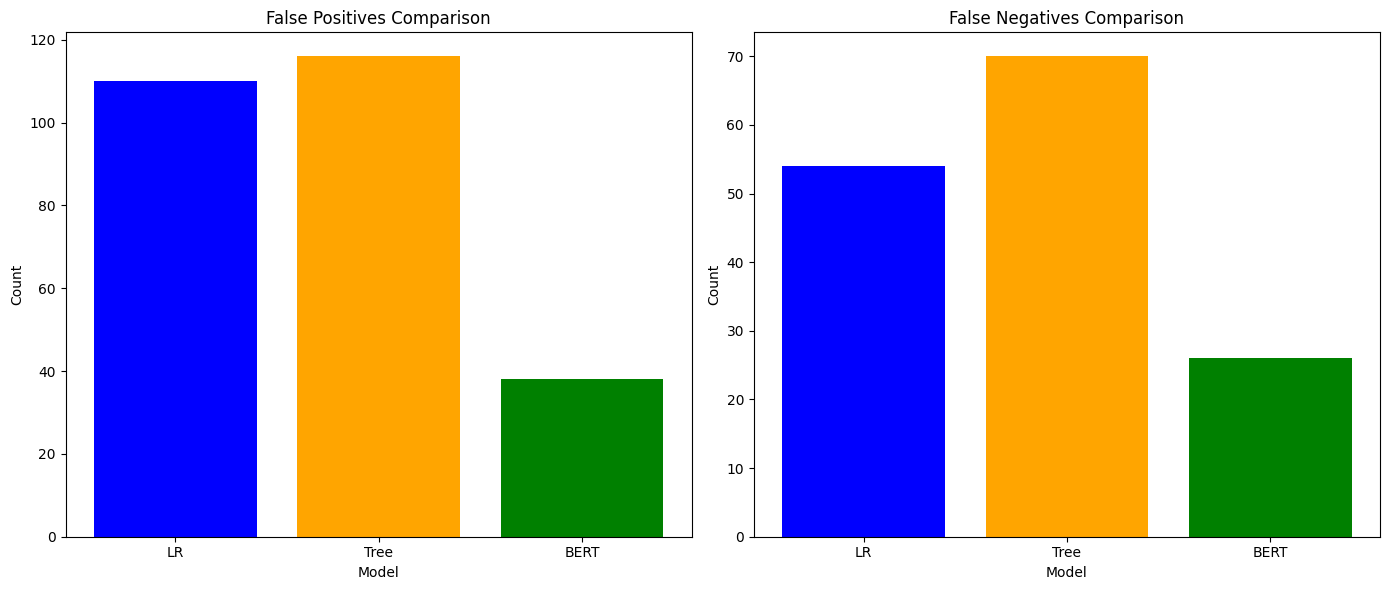

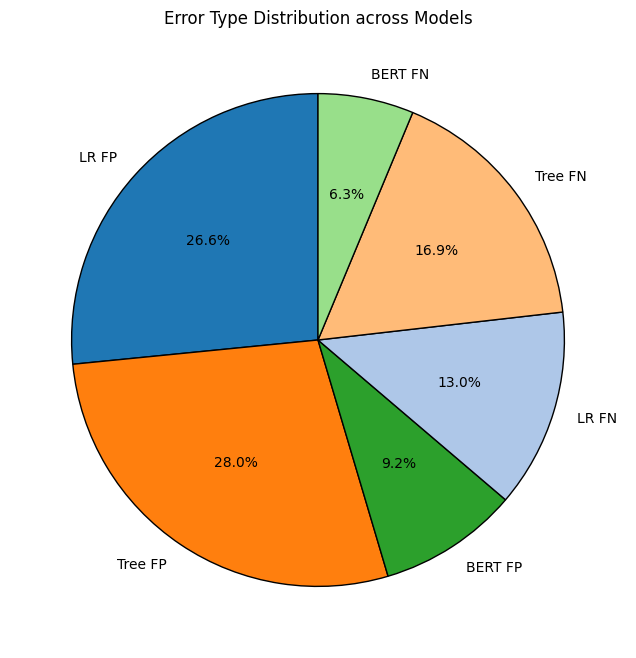

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

false_positives_lr = df_test[(df_test["true_label"] == -1) & (df_test["predicted_label"] == 1)]
false_negatives_lr = df_test[(df_test["true_label"] == 1) & (df_test["predicted_label"] == -1)]

false_positives_tree = df_test_tree[(df_test_tree["true_label"] == -1) & (df_test_tree["predicted_label"] == 1)]
false_negatives_tree = df_test_tree[(df_test_tree["true_label"] == 1) & (df_test_tree["predicted_label"] == -1)]

false_positives_bert = df_test_bert[(df_test_bert["true_label"] == -1) & (df_test_bert["predicted_label"] == 1)]
false_negatives_bert = df_test_bert[(df_test_bert["true_label"] == 1) & (df_test_bert["predicted_label"] == -1)]

#total number of errors
false_pos_lr_count = len(false_positives_lr)
false_neg_lr_count = len(false_negatives_lr)
false_pos_tree_count = len(false_positives_tree)
false_neg_tree_count = len(false_negatives_tree)
false_pos_bert_count = len(false_positives_bert)
false_neg_bert_count = len(false_negatives_bert)

# comparative dataframe
comparison_data = {
    "Model": ["Logistic Regression", "Logistic Regression",
              "Dependency Tree", "Dependency Tree",
              "Transformers", "Transformers"],
    "Error Type": ["False Positives", "False Negatives",
                   "False Positives", "False Negatives",
                   "False Positives", "False Negatives"],
    "Count": [false_pos_lr_count, false_neg_lr_count,
              false_pos_tree_count, false_neg_tree_count,
              false_pos_bert_count, false_neg_bert_count]
}

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(['LR', 'Tree', 'BERT'],
          [false_pos_lr_count, false_pos_tree_count, false_pos_bert_count],
          color=['blue', 'orange', 'green'])
ax[0].set_title("False Positives Comparison")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Model")

ax[1].bar(['LR', 'Tree', 'BERT'],
          [false_neg_lr_count, false_neg_tree_count, false_neg_bert_count],
          color=['blue', 'orange', 'green'])
ax[1].set_title("False Negatives Comparison")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Model")

plt.tight_layout()
plt.show()

# pie chart
labels = ['LR FP', 'Tree FP', 'BERT FP', 'LR FN', 'Tree FN', 'BERT FN']
sizes = [false_pos_lr_count, false_pos_tree_count, false_pos_bert_count,
         false_neg_lr_count, false_neg_tree_count, false_neg_bert_count]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#aec7e8', '#ffbb78', '#98df8a']

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
ax.set_title("Error Type Distribution across Models")
plt.show()